# Autoencoders

- Following notebook demonstrates basic implementations of autoencoders using mnist img data.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

### load dataset

In [11]:
data = pd.read_csv('datasets/mnist/mnist_train.csv')
print(data.shape)
data.head(3)

(60000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
y = data['label']
X = data.drop(['label'],axis=1)
X.head(1)

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(42000, 784) (42000,)
(18000, 784) (18000,)


In [17]:
print(y_train[0])
X_train.head(2)

5


,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
50049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42000 entries, 50049 to 52734
Columns: 784 entries, 1x1 to 28x28
dtypes: int64(784)
memory usage: 251.5 MB


In [20]:
def plot_image(img_arr):
    plt.figure
    plt.imshow(img_arr,cmap="gray")
    plt.show()

Image Value :-  0


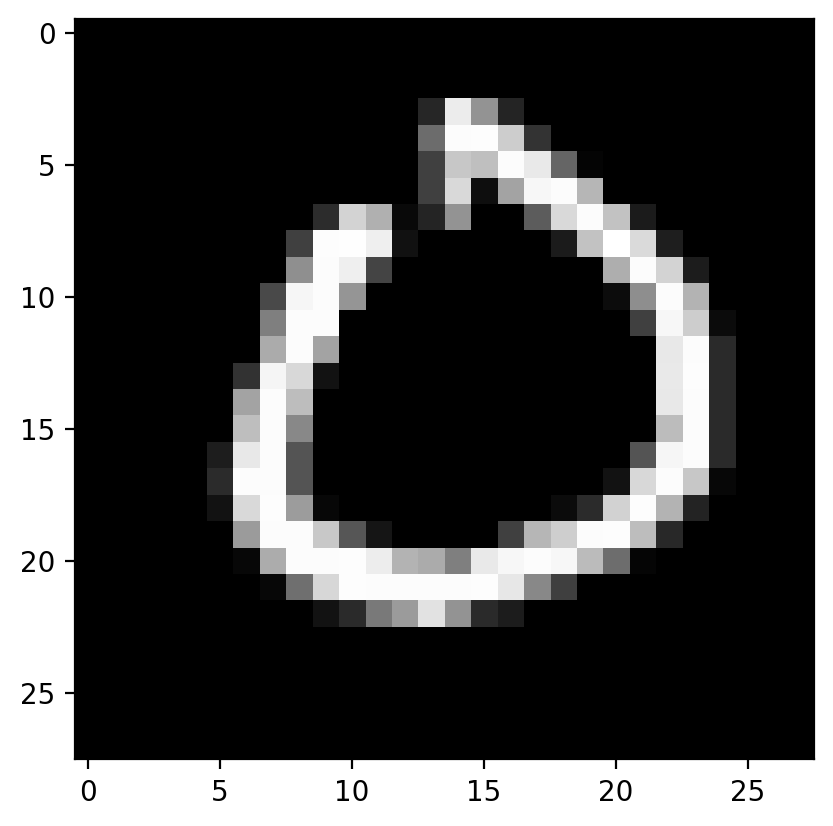

In [47]:
print('Image Value :- ',y_train.values[5])
plot_image(np.array(X_train.iloc[5,:]).reshape((28,28)))

In [50]:
X_train_final = X_train.values
print(len(X_train_final))

42000


In [145]:
X_train_final = X_train_final.astype('float32') / 255.0

In [83]:
len(X_train_final[0])

784

In [147]:
X_train_final[0][:12]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Pytorch Implemetation

In [106]:
import torch
import torch.nn as nn

from torch.nn.utils.clip_grad import clip_grad_norm

In [107]:
# data loader class
class my_data_loader:
    def __init__(self,img_arr):
        '''img_all dtype should be list or numpy array !
           img_all , a list of img data
        '''
        self.img_arr = img_arr
    
    def __len__(self):
        return len(self.img_arr)
    
    def __getitem__(self,idx):
        img_ = np.array(self.img_arr[idx],dtype="float32")        
        return {"img_ar":img_}
        

In [127]:
class Model(nn.Module):
    def __init__(self,in_dim,op_dim,code_dim):
        super(Model,self).__init__()
        # Encoder layer
        self.enc1 = nn.Sequential(nn.Linear(in_dim,512),nn.ReLU6())
        self.enc2 = nn.Sequential(nn.Linear(512,code_dim),nn.ReLU6())
        # code layer
        self.code = nn.Sequential(nn.Linear(code_dim,code_dim),nn.ReLU6())
        # Decoder layer
        self.dec1 = nn.Sequential(nn.Linear(code_dim,512),nn.ReLU6())
        self.dec2 = nn.Sequential(nn.Linear(512,in_dim),nn.Sigmoid())
    
    def forward(self,input_img):
        enc_out1 = self.enc1(input_img)
        enc_out2 = self.enc2(enc_out1)
        code_out = self.code(enc_out2)
        dec_out1 = self.dec1(code_out)
        dec_out2 = self.dec2(dec_out1)
        return dec_out2

In [148]:
train_batch_size = 64

train_data = my_data_loader(img_arr=X_train_final)
train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=train_batch_size,shuffle=True)

In [149]:
train_data[0]["img_ar"].shape

(784,)

In [150]:
def train(model, optimizer, scheduler, loss_function, epochs,train_dataloader, clip_value=2):
    model.train()
    for epoch in range(epochs):
        best_loss = []
        for step, batch in enumerate(train_dataloader): 
            batch_inputs = batch['img_ar']
            model.zero_grad()
            outputs = model(input_img=batch_inputs)
            loss = loss_function(outputs,batch_inputs)
            best_loss.append(loss)
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
#             print(f"step > {step},loss > {loss}")
        loss2 = sum(best_loss)/len(best_loss)
        print(f'Epoch : {epoch} ,Train loss : {loss2}')
                
    return model


In [151]:
epochs = 3
num_train_steps = len(train_data_loader) * epochs
input_dim, output_dim  = len(X_train_final[0]),len(X_train_final[0])
code_dim = 64

model = Model(in_dim=input_dim,op_dim=output_dim,code_dim=code_dim)

optimizer = torch.optim.AdamW(model.parameters(),lr=3e-5,eps=1e-8)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)

loss_function = nn.BCELoss()


model = train(model, optimizer, scheduler, loss_function, epochs,train_dataloader)

Epoch : 0 ,Train loss : 0.3567396104335785
Epoch : 1 ,Train loss : 0.2531765103340149
Epoch : 2 ,Train loss : 0.23077304661273956


In [152]:
torch.save(model.state_dict(),f'./my_autoencoder_model')

### test the autoencoder

In [153]:
x_test_final = X_test.values
x_test_final = x_test_final.astype('float32') / 255.0
# len(y_train_final)
x_test_final[0].shape

(784,)

In [198]:
def predict_single_img(model,test_img):
    res=[]
    model.eval()
    with torch.no_grad():
        output = model(test_img)
    # print(output)
    res=np.array(output*255,dtype="int64")
    res = np.resize(res,(28,28))
    return res


In [199]:
def convert_test_input_img(ar):
    return torch.tensor(ar,dtype=torch.float32)

In [205]:
# model = model()
# model.load_state_dict(torch.load('my_autoencoder_model'))
test_idx = 10

test_img = convert_test_input_img(x_test_final[test_idx])
orig_img = np.resize(x_test_final[test_idx],(28,28))

res = predict_single_img(model,test_img)

In [206]:
def plot_image_output(img_arr_pred,img_arr_orig):
    plt.figure
    plt.subplot(1,2,1)
    plt.imshow(img_arr_pred,cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(img_arr_orig,cmap="gray")
    plt.tight_layout()
    plt.show()

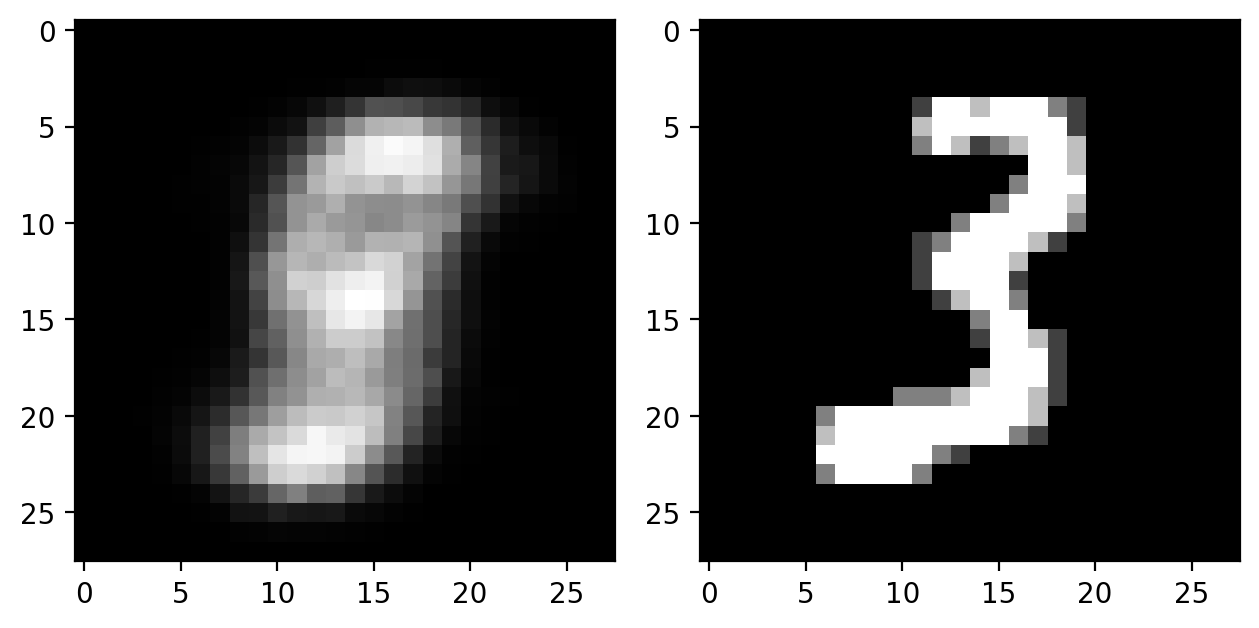

In [207]:
plot_image_output(res,orig_img)